<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90%E5%90%84%E7%A8%AE%E7%AE%97%E6%B3%95%E4%BB%A3%E7%A2%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# get_oof

In [0]:
from sklearn.model_selection import KFold
def get_oof(model ,x_train, y_train, x_test):
    kf = KFold(n_splits=5,random_state=0)
    oof_train = np.zeros((len(x_train),))
    oof_test = np.zeros((len(x_test),))
    oof_test_skf = np.empty((5, len(x_test)))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        model.fit(x_tr, y_tr)

        oof_train[test_index] = model.predict(x_te)
        oof_test_skf[i, :] = model.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import warnings 
warnings.simplefilter('ignore')

def 集成學習(X_train,y_train,X_test,tuning_meta_model=False,meta_model_params=None):
  X_train = X_train.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)
  
  # def base model
  base_models = [
      RandomForestRegressor(random_state=0),
      LinearRegression(),
      KNeighborsRegressor(),
      XGBRegressor(objective="reg:squarederror",random_state=0)]
  
  # def meta model
  meta_model = SVR()
  
  # get all base model's oof_train and oof_test
  all_oof_train = np.empty((len(X_train),0))
  all_oof_test = np.empty((len(X_test),0))
  for model in base_models:
    oof_train,oof_test = get_oof(model,X_train,y_train,X_test)
    all_oof_train = np.hstack((all_oof_train,oof_train))
    all_oof_test = np.hstack((all_oof_test,oof_test))

  # train and tunning meta model
  if tuning_meta_model == True:
    cv = RandomizedSearchCV(estimator = meta_model,
                            param_distributions = meta_model_params,
                            n_jobs = -1,
                            n_iter = 20,
                            cv = 3)
    cv.fit(all_oof_train,y_train)
    meta_model = cv.best_estimator_
  
  # not tunning meta model
  if tuning_meta_model == False:
    meta_model.fit(all_oof_train,y_train)
  
  # return meta model predict
  return meta_model.predict(all_oof_test)

# 評估

In [0]:
from sklearn.metrics import r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def mape(y_true, y_pred,dropinf=False):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ape = np.abs((y_true - y_pred) / y_true)
    if dropinf == True:
      ape = ape[np.isfinite(ape)]
    return np.mean(ape) * 100

def metric(y_true,y_pred,y_name):
  R2 = r2_score(y_true,y_pred)
  RMSE = rmse(y_true,y_pred)
  MAPE = mape(y_true,y_pred)
  return pd.DataFrame({'R2':R2,'RMSE':RMSE,'MAPE':MAPE},index=[y_name])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# trainset

In [5]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/輕油實驗數據(保留大部份欄位,三個基本規則清洗過).csv')
X = train[['T10','T50','T90','N+A in Feed']].rename(columns={'N+A in Feed':'NA'})
y = train.iloc[:,17:-1]
train = X.join(y)
train.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# testset

In [6]:
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/test_without_outlier.csv')
X_test = test[['T10','T50','T90','N+A']].rename(columns={'N+A':'NA'})
y_test = test.iloc[:,4:]
y_test.columns = y.columns
test = X_test.join(y_test)
test.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,98.6,119.2,146.1,40.133,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,105.4,122.2,148.2,32.175,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,105.8,122.7,149.2,31.428,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,105.4,122.4,147.6,31.390,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,105.4,122.6,148.2,32.418,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


# 特徵工程

In [0]:
def 特徵工程(df):
  df['T90-T50'] = df['T90'] - df['T50']
  df['T50-T10'] = df['T50'] - df['T10']
  return df

In [8]:
X = 特徵工程(X)
train = X.join(y)
print(train.shape)
train.head()

(4521, 29)


,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,27.3,18.7,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,27.6,18.3,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,26.8,18.8,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,24.3,18.2,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,24.1,17.7,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


In [9]:
X_test = 特徵工程(X_test)
test = X_test.join(y_test)
print(test.shape)
test.head()

(170, 29)


,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,98.6,119.2,146.1,40.133,26.9,20.6,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,105.4,122.2,148.2,32.175,26.0,16.8,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,105.8,122.7,149.2,31.428,26.5,16.9,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,105.4,122.4,147.6,31.390,25.2,17.0,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,105.4,122.6,148.2,32.418,25.6,17.2,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


# 專業分群

In [10]:
from xgboost import XGBClassifier
cut_num = 5
#訓練資料均溫
train['AVG_T'] = train[['T10','T50','T90']].mean(axis=1)
#測試資料均溫
test['AVG_T'] = test[['T10','T50','T90']].mean(axis=1)
#訓練資料依據均溫切群
train['群代碼'] = pd.qcut(train['AVG_T'],cut_num,labels = [ i for i in range(cut_num)]).astype('int')
#利用4000筆資料訓練一個分群器
xgb_c = XGBClassifier().fit(train[['AVG_T']].sample(4000,random_state=0),train['群代碼'].sample(4000,random_state=0))
print('預測準度:',xgb_c.score(train[['AVG_T']],train['群代碼']))
#利用分群器對測試資料產生群代碼
test['群代碼'] = xgb_c.predict(test[['AVG_T']])

預測準度: 1.0


# 檢查資料(應有特徵工程項和群落標籤)

In [11]:
train.head()

,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,AVG_T,群代碼
0,100.5,119.2,146.5,31.978,27.3,18.7,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,122.066667,3
1,99.6,117.9,145.5,31.568,27.6,18.3,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,121.000000,2
2,100.0,118.8,145.6,31.344,26.8,18.8,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,121.466667,2
3,100.4,118.6,142.9,31.453,24.3,18.2,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,120.633333,2
4,100.4,118.1,142.2,32.190,24.1,17.7,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,120.233333,2


In [12]:
test.head()

,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,AVG_T,群代碼
0,98.6,119.2,146.1,40.133,26.9,20.6,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597,121.300000,2
1,105.4,122.2,148.2,32.175,26.0,16.8,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484,125.266667,4
2,105.8,122.7,149.2,31.428,26.5,16.9,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456,125.900000,4
3,105.4,122.4,147.6,31.390,25.2,17.0,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449,125.133333,4
4,105.4,122.6,148.2,32.418,25.6,17.2,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463,125.400000,4


# 觀察各群落成份分布

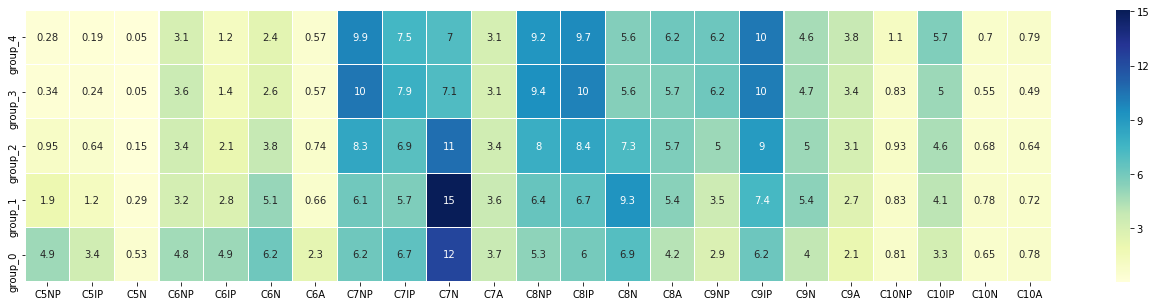

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
table = pd.DataFrame(index=['group_'+str(群代碼) for 群代碼 in range(cut_num)],columns=y.columns)

#根據不同群和y_name找出其均值
for y_name in y.columns:
  for 群代碼 in range(cut_num):
    均值 = round(train[train['群代碼']==群代碼][y_name].mean(),2)
    table.loc[['group_'+str(群代碼)],[y_name]] = 均值

#繪圖
plt.figure(figsize=(23,cut_num))
sns.heatmap(table.astype(float)[::-1],annot=True,linewidths=0.1,cmap='YlGnBu')

# Def x_col,y_col

In [14]:
x_columns = X.columns.tolist()
y_columns = y.columns.tolist()
print(x_columns)
print(y_columns)

['T10', 'T50', 'T90', 'NA', 'T90-T50', 'T50-T10']
['C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A']


# features scaler

In [0]:
def data_scaler(my_data,my_scaler):
  new_data = my_scaler.transform(my_data)
  return pd.DataFrame(new_data ,index=my_data.index ,columns=my_data.columns)

In [0]:
def inv_data_scaler(my_data,my_scaler):
  new_data = my_scaler.inverse_transform(my_data)
  return pd.DataFrame(new_data ,index=my_data.index ,columns=my_data.columns)

In [17]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(train[x_columns])
X_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
train[x_columns] = data_scaler(train[x_columns],X_scaler)
print(train.shape)
train.head()

(4521, 31)


,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,AVG_T,群代碼
0,0.435162,0.540969,0.471798,-1.028321,-0.271410,-0.215543,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,122.066667,3
1,0.353320,0.340075,0.237602,-1.077598,-0.216620,-0.282650,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,121.000000,2
2,0.389694,0.479156,0.261022,-1.104520,-0.362727,-0.198766,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,121.466667,2
3,0.426068,0.448249,-0.371307,-1.091419,-0.819310,-0.299427,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,120.633333,2
4,0.426068,0.370982,-0.535244,-1.002841,-0.855837,-0.383311,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,120.233333,2


In [19]:
test[x_columns] = data_scaler(test[x_columns],X_scaler)
print(test.shape)
test.head()

(170, 31)


,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,AVG_T,群代碼
0,0.262385,0.540969,0.378120,-0.048196,-0.344464,0.103216,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597,121.300000,2
1,0.880744,1.004573,0.869931,-1.004644,-0.508834,-0.534302,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484,125.266667,4
2,0.917118,1.081840,1.104127,-1.094424,-0.417517,-0.517525,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456,125.900000,4
3,0.880744,1.035480,0.729414,-1.098991,-0.654940,-0.500748,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449,125.133333,4
4,0.880744,1.066386,0.869931,-0.975439,-0.581887,-0.467194,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463,125.400000,4


# 查看分數

In [0]:
def get_score(y_pred,y_test):
  res = pd.DataFrame()
  for y_name in y_test.columns:
    res = res.append(metric(y_test[y_name],y_pred[y_name],y_name))
  res.loc['AVG'] = res.mean()
  return res 

# 單純建模表現

In [0]:
from tqdm import tqdm_notebook as tqdm

In [22]:
def 單純建模結果():
  #預測值表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)
  #填表格
  for y_name in tqdm(y_columns):
    y_pred.loc[:,y_name] = SVR().fit(train[x_columns],train[y_name]).predict(test[x_columns])
  #分數
  return get_score(y_pred,y_test)
res_1 = 單純建模結果()
res_1

,R2,RMSE,MAPE
C5NP,0.872199,0.305508,30.880549
C5IP,0.737729,0.262067,46.528714
C5N,0.799409,0.061313,215.012096
C6NP,0.151625,0.372645,6.192081
C6IP,0.859339,0.392024,9.792230
C6N,0.865364,0.607647,5.832102
C6A,0.202542,0.152569,16.623003
C7NP,0.976248,0.338942,3.520847
C7IP,0.861071,0.411871,4.425818
C7N,0.978217,0.615062,3.652725


#集成學習表現

In [23]:


def 單純集成學習結果():
  #預測值表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #填表
  for y_name in tqdm(y_columns):
    y_pred.loc[:,y_name] = 集成學習(train[x_columns],train[y_name],test[x_columns])

  #分數
  return get_score(y_pred,y_test)
res_2 = 單純集成學習結果()
res_2

,R2,RMSE,MAPE
C5NP,0.891809,0.281093,43.502759
C5IP,0.718994,0.271265,83.631291
C5N,0.934916,0.034924,41.125200
C6NP,0.144888,0.374121,6.597490
C6IP,0.895177,0.338419,9.364168
C6N,0.896161,0.533642,6.739722
C6A,0.407313,0.131530,16.322987
C7NP,0.983344,0.283831,3.158798
C7IP,0.848534,0.430053,5.252087
C7N,0.976492,0.638953,3.792353


# 集成學習加調參表現

In [27]:
def 集成學習加調參結果():
  #參數池
  params_1 = {
    'C': np.arange(1 ,20 ,1),
  }
  #表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)
  #填表
  for y_name in tqdm(y_columns):
    y_pred.loc[:,y_name] = 集成學習(train[x_columns],train[y_name],test[x_columns],
                                tuning_meta_model = True,
                                meta_model_params = params_1)
  #分數
  return get_score(y_pred,y_test)
res_3 = 集成學習加調參結果()
res_3

,R2,RMSE,MAPE
C5NP,0.892411,0.280310,41.417962
C5IP,0.718994,0.271265,83.631291
C5N,0.934916,0.034924,41.125200
C6NP,0.190261,0.364061,6.533013
C6IP,0.903782,0.324230,9.204118
C6N,0.894521,0.537841,6.765820
C6A,0.407313,0.131530,16.322987
C7NP,0.983344,0.283831,3.158798
C7IP,0.848534,0.430053,5.252087
C7N,0.975243,0.655705,3.822855


# 專業分群加集成學習結果

In [28]:
import warnings 
warnings.simplefilter('ignore')
def 專業分群加集成學習結果():
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    for y_name in tqdm(y_columns):
      y_pred.loc[群落_test.index,y_name] = 集成學習(群落_train[x_columns],
                                                   群落_train[y_name],
                                                   群落_test[x_columns])

  #分數
  return get_score(y_pred,y_test)
res_4 = 專業分群加集成學習結果()
res_4

,R2,RMSE,MAPE
C5NP,0.889465,0.284122,40.797332
C5IP,0.752366,0.254649,78.967932
C5N,0.770708,0.065552,211.781038
C6NP,-0.056003,0.415752,7.200341
C6IP,0.899052,0.332104,9.251778
C6N,0.841765,0.658751,6.562694
C6A,0.565571,0.112609,14.497710
C7NP,0.981160,0.301871,3.452312
C7IP,0.872078,0.395218,5.068226
C7N,0.936949,1.046423,4.364880


# 序列預測加集成學習加專業分群

In [29]:
def 序列預測_集成學習_專業分群():
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    
    群落_X_train = 群落_train[x_columns]
    群落_X_test = 群落_test[x_columns]
    
    for y_name in tqdm(y_columns):
      群落_y_train = 群落_train[y_name]
      群落_y_pred = 集成學習(群落_X_train,
                            群落_y_train,
                            群落_X_test)
      
      y_pred.loc[群落_X_test.index,y_name] = 群落_y_pred
      
      群落_X_train[y_name] = 群落_y_train
      群落_X_test[y_name]  = 群落_y_pred

  #分數
  return get_score(y_pred,y_test)
res_5 = 序列預測_集成學習_專業分群()
res_5

,R2,RMSE,MAPE
C5NP,0.889465,0.284122,40.797332
C5IP,0.747151,0.257316,97.649301
C5N,0.798586,0.061438,224.998153
C6NP,-0.324995,0.465702,8.892050
C6IP,0.827385,0.434274,13.209001
C6N,0.868423,0.600703,9.723392
C6A,0.716487,0.090970,12.911061
C7NP,0.968562,0.389948,4.339395
C7IP,0.863309,0.408540,4.981960
C7N,0.975921,0.646669,3.933091


# 序列預測加集成學習加專業分群加調參

In [30]:
def 序列預測_集成學習_專業分群_調參():
  #參數池_1
  params_1 = {
    'C': np.arange(1 ,20 ,1)
  }
  
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    
    群落_X_train = 群落_train[x_columns]
    群落_X_test = 群落_test[x_columns]
    
    for y_name in tqdm(y_columns):
      群落_y_train = 群落_train[y_name]
      群落_y_pred = 集成學習(群落_X_train,
                            群落_y_train,
                            群落_X_test,
                            tuning_meta_model=True,
                            meta_model_params=params_1)
      
      y_pred.loc[群落_X_test.index,y_name] = 群落_y_pred
      
      群落_X_train[y_name] = 群落_y_train
      群落_X_test[y_name]  = 群落_y_pred

  #分數
  return get_score(y_pred,y_test)
res_6 = 序列預測_集成學習_專業分群_調參()
res_6

,R2,RMSE,MAPE
C5NP,0.885521,0.289147,40.976915
C5IP,0.739402,0.261230,87.108227
C5N,0.840067,0.054747,203.456031
C6NP,-0.317244,0.464338,8.578077
C6IP,0.835049,0.424523,12.634180
C6N,0.875927,0.583323,9.030538
C6A,0.718840,0.090592,12.657315
C7NP,0.971657,0.370256,4.237417
C7IP,0.868393,0.400870,4.964373
C7N,0.982888,0.545141,3.711716


#分數比較

In [31]:
df = pd.DataFrame({'單純SVR':res_1.RMSE,
                   '單純集成學習':res_2.RMSE,
                   '集成學習&調參':res_3.RMSE,
                   '專業分群&集成學習':res_4.RMSE,
                   '集成學習&專業分群&序列預測':res_5.RMSE,
                   '集成學習&專業分群&序列預測&調參':res_6.RMSE})
print('紅色代表RMSE最低')
df.style.apply(lambda x: ["background: red" if v == np.min(x) else "" for v in x], axis = 1)

紅色代表RMSE最低


,單純SVR,單純集成學習,集成學習&調參,專業分群&集成學習,集成學習&專業分群&序列預測,集成學習&專業分群&序列預測&調參
C5NP,0.305508,0.281093,0.28031,0.284122,0.284122,0.289147
C5IP,0.262067,0.271265,0.271265,0.254649,0.257316,0.26123
C5N,0.0613127,0.0349245,0.0349245,0.0655524,0.0614384,0.0547474
C6NP,0.372645,0.374121,0.364061,0.415752,0.465702,0.464338
C6IP,0.392024,0.338419,0.32423,0.332104,0.434274,0.424523
C6N,0.607647,0.533642,0.537841,0.658751,0.600703,0.583323
C6A,0.152569,0.13153,0.13153,0.112609,0.0909703,0.090592
C7NP,0.338942,0.283831,0.283831,0.301871,0.389948,0.370256
C7IP,0.411871,0.430053,0.430053,0.395218,0.40854,0.40087
C7N,0.615062,0.638953,0.655705,1.04642,0.646669,0.545141


# 保存res

In [32]:
res_1.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/單純SVR.xlsx')
res_2.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/單純集成學習(SVR).xlsx')
res_3.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&調參(SVR).xlsx')
res_4.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/專業分群&集成學習(SVR).xlsx')
res_5.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&專業分群&序列預測(SVR).xlsx')
res_6.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&專業分群&序列預測&調參(SVR).xlsx')
print('save done!')

save done!
